#  This is Lab 2 executable file
This file contains the program code that is the solution to the tasks from the file [lab_2_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_2/lab_2_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [60]:
# libs initialization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.optimize import curve_fit 
import seaborn as sns
import urllib.request
import os
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [61]:
# Dataset initialization
path_to_file = '../Datasets/GameStats.csv'
source_df = pd.read_csv(path_to_file, engine='python')
# source_df.columns = ["V"+str(i) for i in range(1, len(source_df.columns)+1)]  # rename column names to be similar to R naming convention
# source_df.V2 = source_df.V2.astype(str)
source_df.head(7)

,Date,Level,NumBlocks,IsWin,ElapsedTime,Score,Accuracy
0,9/7/2019 2:43:29 PM,520,30,False,1.58000,150,0.00000
1,9/7/2019 2:44:46 PM,520,30,False,3.80500,100,0.00000
2,9/7/2019 2:59:20 PM,520,30,False,1.78301,50,0.00000
3,9/7/2019 2:59:28 PM,520,30,True,0.26302,0,0.00000
4,9/7/2019 2:59:48 PM,520,30,True,3.31802,50,0.00000
5,9/7/2019 2:59:56 PM,520,30,True,3.67703,0,0.00000
6,9/7/2019 3:00:15 PM,520,30,False,3.16800,100,0.00000


Date:        date and time the game was auto-played

Level:       the 3-digit number is an estimate of the difficulty from a previous run

NumBlocks:   how many blocks have to be broken to win the level

IsWin:       True if autoplay broke all the blocks, False if the ball fell past the paddle

ElapsedTime: Seconds until either won or lost (game is played at 4x speed, so multiply by 4 to get an estimate of how long a human might play it)

Score:       total score when the game was won or lost

Accuracy:    the autoplay is tuned with a randomly-chosen accuracy. Higher numbers are more likely to win;

In [62]:
# Colums renaming and data preparation
source_df.Level = source_df.Level.astype(str)
epoch = datetime(2019, 9, 7)

for i in range(0, len(source_df['Date'])):
    temptime = datetime.strptime(source_df['Date'][i], '%m/%d/%Y %I:%M:%S %p')
    td = temptime - epoch
    source_df['Date'][i] = td.days * 86400 + td.seconds
source_df['Date'] = source_df['Date'].astype(int)
source_df['NumBlocks'] = source_df['NumBlocks'].astype(int)
source_df.head(7)
# b = sns.lmplot("Accuracy", "Score", source_df, hue="Level", fit_reg=False)
# b.set(xlim=(0.29, 0.41))
# b.fig.set_size_inches(20,10)


/var/folders/ky/fcbbxgqj4xbchr5qk956cd3r0000gn/T/ipykernel_4937/3454802930.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_df['Date'][i] = td.days * 86400 + td.seconds


,Date,Level,NumBlocks,IsWin,ElapsedTime,Score,Accuracy
0,53009,520,30,False,1.58000,150,0.00000
1,53086,520,30,False,3.80500,100,0.00000
2,53960,520,30,False,1.78301,50,0.00000
3,53968,520,30,True,0.26302,0,0.00000
4,53988,520,30,True,3.31802,50,0.00000
5,53996,520,30,True,3.67703,0,0.00000
6,54015,520,30,False,3.16800,100,0.00000


## Exercise №1
You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).

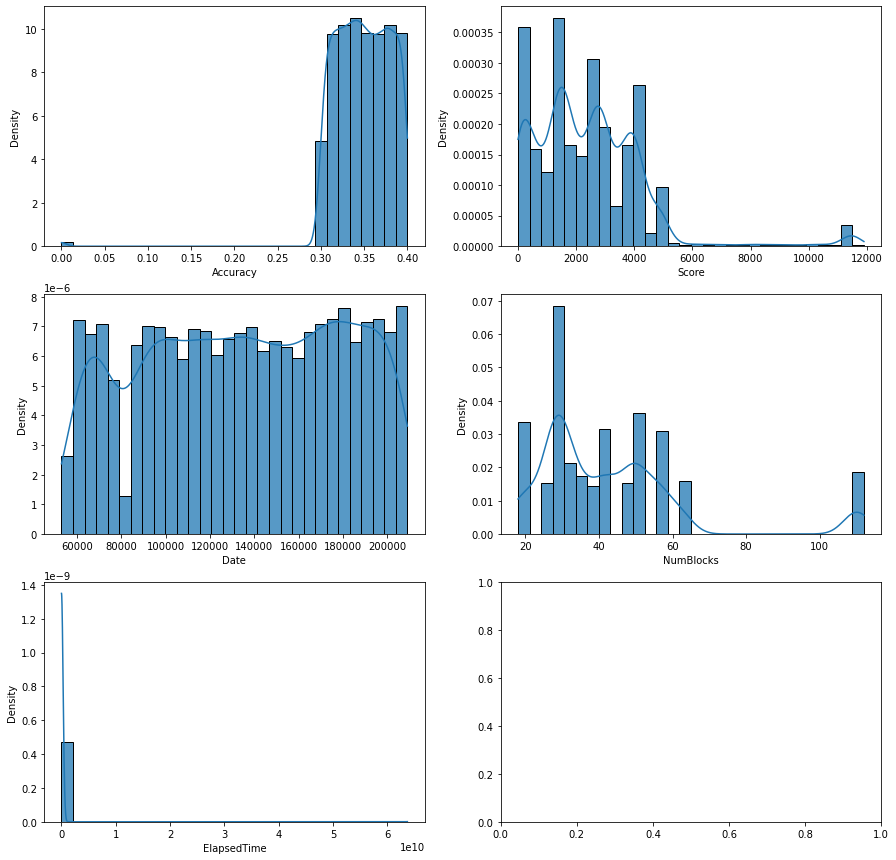

In [74]:
nbins = 30

# Price
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
kernel = scipy.stats.gaussian_kde(source_df["Accuracy"])
min_amount, max_amount = source_df["Accuracy"].min(), source_df["Accuracy"].max()
x = np.linspace(min_amount, max_amount, len(source_df["Accuracy"]))
kde_values = kernel(x)
sns.histplot(source_df["Accuracy"], kde=False, bins=nbins, stat='density', ax=ax[0, 0], palette='Set3')
ax[0, 0].plot(x, kde_values)
# ax[0, 0].set_title('Price')

# Dividend Yield
kernel = scipy.stats.gaussian_kde(source_df["Score"])
min_amount, max_amount = source_df["Score"].min(
), source_df["Score"].max()
x = np.linspace(min_amount, max_amount, len(source_df["Score"]))
kde_values = kernel(x)
sns.histplot(source_df["Score"], kde=False, bins=nbins, stat='density', ax=ax[0, 1], palette='Set3')
ax[0, 1].plot(x, kde_values)
# ax[0, 1].set_title("Score")

# Earnings/Share
kernel = scipy.stats.gaussian_kde(source_df["Date"])
min_amount, max_amount = source_df["Date"].min(), source_df["Date"].max()
x = np.linspace(min_amount, max_amount, len(source_df["Date"]))
kde_values = kernel(x)
sns.histplot(source_df["Date"], kde=False, bins=nbins, stat='density', ax=ax[1, 0], palette='Set3')
ax[1, 0].plot(x, kde_values)
# ax[1, 0].set_title("Date")

# 52 week low
kernel = scipy.stats.gaussian_kde(source_df["NumBlocks"])
min_amount, max_amount = source_df["NumBlocks"].min(), source_df["NumBlocks"].max()
x = np.linspace(min_amount, max_amount, len(source_df["NumBlocks"]))
kde_values = kernel(x)
sns.histplot(source_df["NumBlocks"], kde=False, bins=nbins, stat='density', ax=ax[1, 1], palette='Set3')
ax[1, 1].plot(x, kde_values)
# ax[1, 1].set_title("NumBlocks")

# 52 week high
kernel = scipy.stats.gaussian_kde(source_df["ElapsedTime"])
min_amount, max_amount = source_df["ElapsedTime"].min(), source_df["ElapsedTime"].max()
x = np.linspace(min_amount, max_amount, len(source_df["ElapsedTime"]))
kde_values = kernel(x)
sns.histplot(source_df["ElapsedTime"], kde=False, bins=nbins, stat='density', ax=ax[2, 0], palette='Set3')
ax[2, 0].plot(x, kde_values)
# ax[2, 0].set_title("ElapsedTime")

# # market cap
# kernel = scipy.stats.gaussian_kde(source_df["Score"])
# min_amount, max_amount = source_df["Score"].min(), source_df["Score"].max()
# x = np.linspace(min_amount, max_amount, len(source_df["Score"]))
# kde_values = kernel(x)
# sns.histplot(source_df["Score"], kde=False, bins=nbins, stat='density', ax=ax[2, 1], palette='Set3')
# ax[2, 1].plot(x, kde_values)
# # ax[2, 1].set_title('Markep Cap')

[[0.000000e+00 1.500000e+02 3.000000e+01]
 [0.000000e+00 1.000000e+02 3.000000e+01]
 [0.000000e+00 5.000000e+01 3.000000e+01]
 ...
 [3.256807e-01 4.000000e+03 5.000000e+01]
 [3.327982e-01 1.300000e+03 1.800000e+01]
 [3.811220e-01 2.100000e+03 6.200000e+01]]


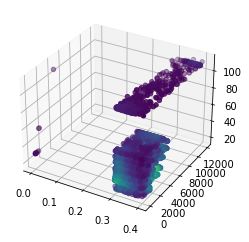

In [64]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

a = source_df["Accuracy"]
b = source_df["Score"]
c = source_df["NumBlocks"]
data = np.zeros(shape=(len(a),3))
for i in range(0, len(a)):
    data[i] = [a[i], b[i], c[i]]
print(data)

values = data.T

kde = stats.gaussian_kde(values)
density = kde(values)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
x, y, z = values
ax.scatter(x, y, z, c=density)
plt.show()

Level                    inf
Date            135121.37995
Accuracy             0.34916
ElapsedTime   46744584.36289
Score             2381.39859
NumBlocks           42.41121
Level_int            8.74831
dtype: float64
Date                   1972156985.39576
Accuracy                        0.00111
ElapsedTime   2976043478376166912.00000
Score                     3681182.26500
NumBlocks                     432.66076
Level_int                      28.62870
dtype: float64


/var/folders/ky/fcbbxgqj4xbchr5qk956cd3r0000gn/T/ipykernel_4937/4092702012.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(subdataset.var(ddof=1))


<AxesSubplot:xlabel='Level_int', ylabel='Score'>

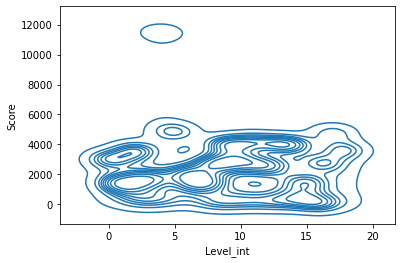

In [65]:
subdataset = source_df[['Level', 'Date', 'Accuracy', 'ElapsedTime', 'Score', 'NumBlocks']]
subdataset['Level_int'] = subdataset['Level'].astype('category')
cat_columns = subdataset.select_dtypes(['category']).columns
subdataset[cat_columns] = subdataset[cat_columns].apply(lambda x: x.cat.codes)
subdataset

subdataset.Level.unique()

print(subdataset.mean())
print(subdataset.var(ddof=1))

subdataset.corr()

sns.kdeplot(data=subdataset, x='Level_int', y='Score')

## Exercise №2
You need to make an estimation of multivariate mathematical expectation and variance.

## Exercise №3
You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances. 

In [66]:
print(subdataset[subdataset.Level=='520'].mean())
print(subdataset[subdataset.Level=='520'].var(ddof=1))
print(subdataset[subdataset.Level=='493'].mean())
print(subdataset[subdataset.Level=='493'].var(ddof=1))

Level                  inf
Date          131870.59956
Accuracy           0.34131
ElapsedTime       17.22831
Score           1871.00656
NumBlocks         29.02845
Level_int          8.00000
dtype: float64
Date          2141672301.46430
Accuracy               0.00418
ElapsedTime          141.93785
Score            1230741.96706
NumBlocks              0.02770
Level_int              0.00000
dtype: float64
Level                  inf
Date          133653.05283
Accuracy           0.34575
ElapsedTime       21.48263
Score           3583.77358
NumBlocks         56.00000
Level_int          5.00000
dtype: float64
Date          1906775979.69417
Accuracy               0.00177
ElapsedTime          182.84457
Score            3256175.10006
NumBlocks              0.00000
Level_int              0.00000
dtype: float64


/var/folders/ky/fcbbxgqj4xbchr5qk956cd3r0000gn/T/ipykernel_4937/1898802467.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(subdataset[subdataset.Level=='520'].var(ddof=1))
/var/folders/ky/fcbbxgqj4xbchr5qk956cd3r0000gn/T/ipykernel_4937/1898802467.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(subdataset[subdataset.Level=='493'].var(ddof=1))


## Exercise №4
You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

In [67]:
pairs = [
    ['Score', 'ElapsedTime'],
    ['Score', 'Accuracy'],
    ['Score', 'NumBlocks'],
    ['Score', 'Date']
    # ['Accuracy', 'Market Cap'],

    # ['Dividend Yield', '52 Week Low'],
    # ['Dividend Yield', '52 Week High'],
    # ['Dividend Yield', 'Earnings/Share'],
    # ['Dividend Yield', 'Market Cap'],

    # ['52 Week Low', '52 Week High'],
    # ['52 Week Low', 'Earnings/Share'],
    # ['52 Week Low', 'Market Cap'],

    # ['52 Week Low', 'Earnings/Share'],
    # ['52 Week Low', 'Market Cap'],

    # ['Earnings/Share', 'Market Cap']
]
for x, y in pairs:
    r, p = scipy.stats.pearsonr(subdataset[x], subdataset[y])
    r_z = np.arctanh(r)  # matches Fisher transform
    # Corresponding standard deviation
    se = 1/np.sqrt(subdataset[x].size-3)
    alpha = 0.05
    z = scipy.stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se

    print('Conf int for the corr coef {} & {}: {:.4f}:{:.4f} '.format(x, y, lo_z, hi_z))


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Conf int for the corr coef Score & ElapsedTime: -0.0157:0.0318 
Conf int for the corr coef Score & Accuracy: 0.2279:0.2754 
Conf int for the corr coef Score & NumBlocks: 0.5476:0.5951 
Conf int for the corr coef Score & Date: -0.0350:0.0125 


## Exercise №5
Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).

In [68]:
# Linear Regression without scaling

# Highlight predictors
X = subdataset[[ 'ElapsedTime', 'Accuracy', 'NumBlocks', 'Date']]
# Allocate the target variable
y = source_df[['Score']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
reg = LinearRegression()
# Train a linear regression model
reg.fit(X_train, y_train)
# Forecast on a test sample
y_pred = reg.predict(X_test)
params = np.append(reg.intercept_, reg.coef_)
print('model parameters:')
print('model weights:', reg.coef_)
print('model bias:', reg.intercept_)


# Calculation of model metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape.squeeze())
print('Determination coefficient = ', reg.score(X_test, y_test))

model parameters:
model weights: [[ 2.18344862e-08  1.37409850e+04  4.99120583e+01 -1.09664151e-03]]
model bias: [-4370.76523219]
Mean absolute error =  1176.0015036933664
Mean squared error =  2488064.8312318004
Mean absolute percentage error =  inf
Determination coefficient =  0.282185566043186


## Exercise №6-7 (Without regulariztion)
6. Build regression model and make an analysis of multicollinearity and regularization (if needed). 
7. Analyze the quality of regression model (distribution of residuals, determination coefficient).

In [69]:
# Linear Regression without Regularization

# Highlight predictors
X = subdataset[[ 'ElapsedTime', 'Accuracy', 'NumBlocks', 'Date']]
# Allocate the target variable
y = source_df[['Score']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
reg = LinearRegression()
# Train a linear regression model
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
y_train = pd.DataFrame(scaler.fit_transform(y_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))
y_test = pd.DataFrame(scaler.fit_transform(y_test))
reg.fit(X_train, y_train)
# Forecast on a test sample
y_pred = reg.predict(X_test)
params = np.append(reg.intercept_, reg.coef_)
print('model parameters:')
print('model weights:', reg.coef_)
print('model bias:', reg.intercept_)


# Calculation of model metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape.squeeze())
print('Determination coefficient = ', reg.score(X_test, y_test))


model parameters:
model weights: [[ 0.01831916  0.23945605  0.53198525 -0.02487335]]
model bias: [-8.53521823e-17]
Mean absolute error =  0.6317650614439023
Mean squared error =  0.7130471253578234
Mean absolute percentage error =  145.40544149180388
Determination coefficient =  0.28695287464217656


(6814,)


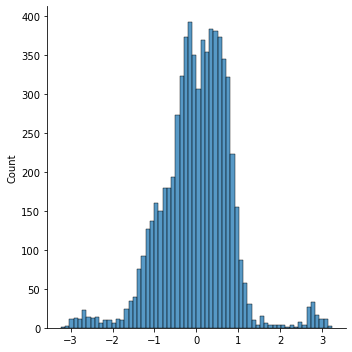

In [70]:
# Highlight predictors
X = subdataset[[ 'ElapsedTime', 'Accuracy', 'NumBlocks', 'Date']]
# Allocate the target variable
y = source_df[['Score']]
X = pd.DataFrame(scaler.fit_transform(X))
y_pred_all = reg.predict(X)
y = pd.DataFrame(scaler.fit_transform(y))
y1 = np.array(y)
y2 = np.array(y_pred_all)
print(y1[:,0].shape)
y_diff = y1[:,0] - y2[:,0]
sns.displot(y_diff, kde=False)

## Exercise №6-7 (With regulariztion)
6. Build regression model and make an analysis of multicollinearity and regularization (if needed). 
7. Analyze the quality of regression model (distribution of residuals, determination coefficient).

In [71]:

# Linear Regression with Regularization

# Highlight predictors
X = subdataset[[ 'ElapsedTime', 'Accuracy', 'NumBlocks', 'Date']]
# Allocate the target variable
y = source_df[['Score']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
lasso = Lasso(alpha=0.1)
# Train a linear regression model
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
y_train = pd.DataFrame(scaler.fit_transform(y_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))
y_test = pd.DataFrame(scaler.fit_transform(y_test))
lasso.fit(X_train, y_train)
# Forecast on a test sample
y_pred = np.expand_dims(lasso.predict(X_test), 1)
params = np.append(lasso.intercept_, lasso.coef_)
print('model parameters:')
print('model weights:', lasso.coef_)
print('model bias:', lasso.intercept_)


# Calculation of model metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape.squeeze())
print('Determination coefficient = ', lasso.score(X_test, y_test))

model parameters:
model weights: [ 0.          0.13919038  0.43347352 -0.        ]
model bias: [-1.02265244e-16]
Mean absolute error =  0.6378698093657373
Mean squared error =  0.7247108368303816
Mean absolute percentage error =  130.6580453620911
Determination coefficient =  0.2752891631696184


(6814,)


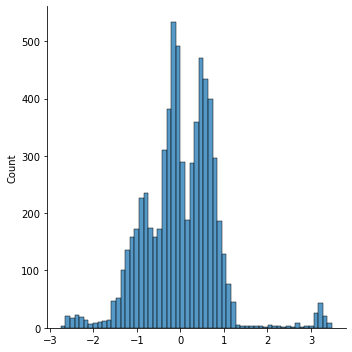

In [72]:
# Highlight predictors
X = subdataset[[ 'ElapsedTime', 'Accuracy', 'NumBlocks', 'Date']]
# Allocate the target variable
y = source_df[['Score']]
X = pd.DataFrame(scaler.fit_transform(X))
y_pred_all = np.expand_dims(lasso.predict(X), 1)
y = pd.DataFrame(scaler.fit_transform(y))
y1 = np.array(y)
y2 = np.array(y_pred_all)
print(y1[:,0].shape)
y_diff = y1[:,0] - y2[:,0]
sns.displot(y_diff, kde=False)